In [1]:
import numpy as np
import matplotlib.pyplot as plt


def reshape_pixels_position_arrays_to_1d(array):
    """
    Only an abbreviation.

    :param array: The position array.
    :return: Reshaped array.
    """
    array_1d = np.reshape(array, [np.prod(array.shape[:-1]), 3])
    return array_1d


def get_polarization_correction(pixel_pos, polarization):
    """
    Obtain the polarization correction.

    :param pixel_pos: The position of each pixel in real space.
    :param polarization: The polarization vector of the incident beam.
    :return: The polarization correction array.
    """
    # reshape the array into a 1d position array
    pixel_pos_1d = reshape_pixels_position_arrays_to_1d(pixel_pos)

    pixel_pos_norm = np.sqrt(np.sum(np.square(pixel_pos_1d), axis=1))
    pixel_pos_direction = pixel_pos_1d / pixel_pos_norm[:, np.newaxis]

    # Calculate the polarization correction
    polarization_norm = np.sqrt(np.sum(np.square(polarization)))
    polarization_direction = polarization / polarization_norm

    polarization_correction_1d = np.sum(np.square(np.cross(pixel_pos_direction,
                                                           polarization_direction)), axis=1)

    # print polarization_correction_1d.shape
    polarization_correction = np.reshape(polarization_correction_1d, pixel_pos.shape[0:-1])

    return polarization_correction


def get_solid_angle(pixel_pos, pixel_area, orientation):
    """
    Calculate the solid angle for each pixel.

    :param pixel_pos: The position of each pixel in real space. In pixel stack format.
    :param orientation: The orientation of the detector.
    :param pixel_area: The pixel area for each pixel. In pixel stack format.
    :return: Solid angle of each pixel.
    """

    # Use 1D format
    pixel_pos_1d = reshape_pixels_position_arrays_to_1d(pixel_pos)
    pixel_pos_norm_1d = np.sqrt(np.sum(np.square(pixel_pos_1d), axis=-1))
    pixel_area_1d = np.reshape(pixel_area, np.prod(pixel_area.shape))

    # Calculate the direction of each pixel.
    pixel_pos_direction_1d = pixel_pos_1d / pixel_pos_norm_1d[:, np.newaxis]

    # Normalize the orientation vector
    orientation_norm = np.sqrt(np.sum(np.square(orientation)))
    orientation_normalized = orientation / orientation_norm

    # The correction induced by projection which is a factor of cosine.
    cosine_1d = np.abs(np.dot(pixel_pos_direction_1d, orientation_normalized))

    # Calculate the solid angle ignoring the projection
    solid_angle_1d = np.divide(pixel_area_1d, np.square(pixel_pos_norm_1d))
    solid_angle_1d = np.multiply(cosine_1d, solid_angle_1d)

    # Restore the pixel stack format
    solid_angle_stack = np.reshape(solid_angle_1d, pixel_area.shape)

    return solid_angle_stack


def get_Q_vec_map(det_shape, wavelength, distance, center, pixel_size, angleRad=np.deg2rad(7)):
    pixel_pos = np.zeros((det_shape[0], det_shape[1], 3))
    pixel_pos[:, :, 2] = distance
    pixel_pos[:, :, 0] = (np.arange(det_shape[0]).astype(np.float64) - center[0])[:, np.newaxis] * pixel_size
    pixel_pos[:, :, 1] = (np.arange(det_shape[1]).astype(np.float64) - center[1])[np.newaxis, :] * pixel_size

    rotmat = np.zeros((3, 3))
    rotmat[0, 0] = 1
    rotmat[1, 1] = np.cos(angleRad)
    rotmat[2, 2] = np.cos(angleRad)
    rotmat[1, 2] = np.sin(angleRad)
    rotmat[2, 1] = -np.sin(angleRad)
    pixel_pos = np.dot(pixel_pos, rotmat.T)

    pixel_direction = pixel_pos / np.linalg.norm(pixel_pos, axis=-1)[:, :, np.newaxis]
    pixel_direction[:, :, 2] -= 1

    q_vecter_map = pixel_direction * (np.pi * 2 / wavelength)

    return q_vecter_map, pixel_pos


qVecMap, pixel_position = get_Q_vec_map(det_shape=(2399, 2399),  # pixel
                                        wavelength=1.23984193,  # A
                                        distance=12.14 * 10 * 1000,  # um
                                        center=(1237.9, 347.9),
                                        pixel_size=50,
                                        )

solid_angle = get_solid_angle(pixel_pos=pixel_position,
                              pixel_area=np.ones((2399, 2399)) * 50 * 50,
                              orientation=np.array([-np.sin(np.deg2rad(7)), 0, np.cos(np.deg2rad(7))])
                              )
polarization_factor = get_polarization_correction(pixel_pos=pixel_position,
                                                  polarization=np.array([1, 0, 0]))


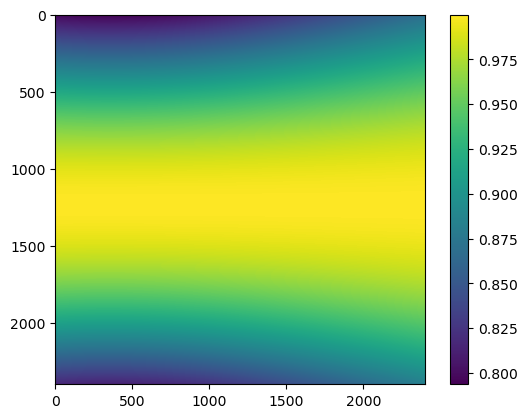

In [2]:
plt.imshow(polarization_factor)
plt.colorbar()
plt.show()

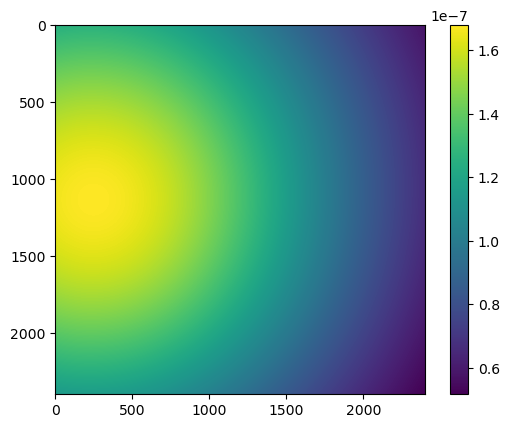

In [3]:
plt.imshow(solid_angle)
plt.colorbar()
plt.show()